**Part A**

Save all the possible classifications that will be tested into a file for later use. 

In [1]:
%matplotlib inline

In [2]:
from analysis_tree_helpers import HTree, Node, get_valid_classifications
import scipy.io as sio
import pandas as pd

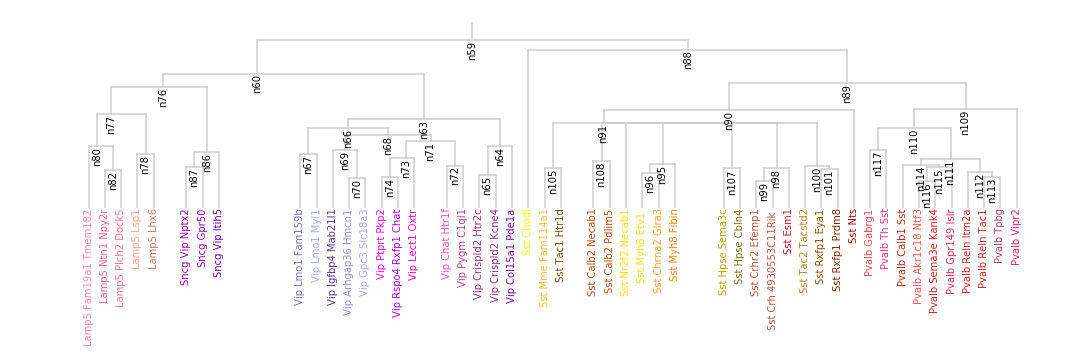

In [3]:
simple_tree_filename = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/dend_RData_Tree_20181220_pruned.csv'
htree_df = pd.read_csv(simple_tree_filename)
htree = HTree(htree_df=htree_df)
htree.plot((15,5),fontsize=10,skeletoncol='#CDCDCD',txtleafonly=False)
ax = plt.gca()
ax.set_xlim(30,95)
ax.axis('off')
plt.tight_layout()

In [4]:
from timebudget import timebudget

with timebudget('Calculate valid classifications'):
    valid_classifications = {}
    for n in ['n60','n88']:
        print('Subtree with root node: {:s}'.format(n))
        subtree = htree.get_subtree(node=n)
        start_node = Node(name=n,C_list=subtree.child,P_list=subtree.parent)
        valid_classifications[n]=[]
        valid_classifications[n] = get_valid_classifications([start_node],
                                                          C_list=subtree.child,
                                                          P_list=subtree.parent,
                                                          valid_classes=valid_classifications[n])

    for n in ['n60','n88']:
        valid_classifications[n].sort(key=len)
        hist_counts = pd.Series([len(classification) for classification in valid_classifications[n]]).value_counts().to_frame()
        hist_counts.reset_index(inplace=True)
        hist_counts = hist_counts.rename(columns={'index':'n_classes',0:'classifications'}).sort_values(by='n_classes').reset_index(drop=True)

        print(hist_counts.to_string())
        print('Total: {:d} \n'.format(len(valid_classifications[n])))

Subtree with root node: n60
Subtree with root node: n88
    n_classes  classifications
0           1                1
1           2                1
2           3                2
3           4                5
4           5               12
5           6               23
6           7               43
7           8               75
8           9              123
9          10              189
10         11              270
11         12              356
12         13              424
13         14              445
14         15              401
15         16              303
16         17              187
17         18               91
18         19               33
19         20                8
20         21                1
Total: 2993 

    n_classes  classifications
0           1                1
1           2                1
2           3                1
3           4                2
4           5                2
5           6                3
6           7                5


In [5]:
#Save dictionary in json format:
import json
classifications_path = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/dat/raw/patchseq-v4/'
classifications_fname = 'PS_v4_beta_0-4_matched_well-sampled_dend_RData_Tree_20181220_pruned_n88_n60_classifications.json'
json_file = json.dumps(valid_classifications)
with open(classifications_path+classifications_fname,"w") as f:
    f.write(json_file)

**Part B** Implemented in `analysis_parallel_classifier.py`

Test set values will be used only once the best classification has been chosen based on validation set results. 
 - Read single cross validation set data
 - Loop over pre-defined classifications
 - Relabel all training, validation, and test set data with merged labels
 - Train a logistic regression model
 - Log hyperparameters, cvset, classification_id, accuracy and ARI for training, validation, and test sets using the classifier.
 
```python
# Most time consuming case:
this_classification = all_classifications[root_node][-1]

# Subtree over which brute force classification is performed:
root_node='n59'
this_classification = ['n60','n88'] #accuracy for this is over 99%
this_classification = ['n76','n63','Sst Chodl','n90','n109']
 ```
 

In [1]:
import csv
import json
import argparse
import sys
import pdb

import numpy as np
import pandas as pd
import scipy.io as sio
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.cluster import adjusted_rand_score
from timebudget import timebudget

from analysis_tree_helpers import HTree


def relabel_restrict_inputs(CV=None,O=None,this_classification=[],descendant_dict={}):
    """Restrict the train, validation and test subsets to relevant portion of the tree, and relabel according to current classification being considered.
    
    Arguments:
        CV -- dict with one of the cross validation sets, with fields `zT`, `zE`, `train_ind`,`val_ind`,`test_ind`
        O -- dict with annotation field `cluster`
        this_classification -- list of labels remaining in the classificaiton
        descendant_dict -- dict with descendants based on the tree
    
    Returns:
        X -- dictionary with train,val and test subsets to train the classifiers.
    """

    X={}
    #Initialize
    for ds in ['train','val','test']:
        X[ds]={}
        X[ds]['zT']=CV['zT'][CV[ds+'_ind'],:].copy()
        X[ds]['zE']=CV['zE'][CV[ds+'_ind'],:].copy()
        X[ds]['orig_cluster']=O['cluster'][CV[ds+'_ind']].copy()
        X[ds]['cluster']=np.array(['rem']*X[ds]['zT'].shape[0],dtype=X[ds]['orig_cluster'].dtype)


    #Relabel
    for ds in ['train','val','test']:
        for label in this_classification:
            #Leaf nodes have an empty value in descendant_dict
            if len(descendant_dict[label])==0:
                X[ds]['cluster'][np.isin(X[ds]['orig_cluster'],label)] = label
            else:
                X[ds]['cluster'][np.isin(X[ds]['orig_cluster'],descendant_dict[label])] = label

    #Remove labels not in current classification
    for ds in ['train','val','test']:
        keep = X[ds]['cluster']!='rem'
        X[ds]['zT']=X[ds]['zT'][keep,:]
        X[ds]['zE']=X[ds]['zE'][keep,:]
        X[ds]['cluster']=X[ds]['cluster'][keep]
        X[ds]['orig_cluster']=X[ds]['orig_cluster'][keep]
    
    return X

def set_paths(exp_name='logistic_classifiers'):
    """Set data paths
    """

    from pathlib import Path   
    dir_pth = {}
    curr_path = str(Path().absolute())
    if '/Users/fruity' in curr_path:
        base_path = '/Users/fruity/Dropbox/AllenInstitute/CellTypes/'
        dir_pth['data'] = base_path + 'dat/raw/patchseq-v4/'
    elif '/home/rohan' in curr_path:
        base_path = '/home/rohan/Dropbox/AllenInstitute/CellTypes/'
        dir_pth['data'] = base_path + 'dat/raw/patchseq-v4/'
    elif '/allen' in curr_path:
        base_path = '/allen/programs/celltypes/workgroups/mousecelltypes/Rohan/'
        dir_pth['data'] = base_path + 'dat/raw/patchseq-v4/'

    dir_pth['cvfolds'] = base_path + 'dat/result/TE_Patchseq_Bioarxiv/'
    dir_pth['result'] = dir_pth['cvfolds'] + exp_name + '/'

    Path(dir_pth['result']).mkdir(parents=True, exist_ok=True)
    return dir_pth

In [2]:
cvfold=0
alpha_T=1.0
alpha_E=0.5
lambda_TE=1.0
root_node='n88'
start_i=0
stop_i=11000
embedding='zE'
rand_seed=0
exp_name='TEST'

alpha_M=alpha_E
cvfold_fname='v1_aT_'+str(alpha_T)+\
            '_aE_'+str(alpha_E)+\
            '_aM_'+str(alpha_M)+\
            '_cs_'+str(lambda_TE)+\
            '_ld_3_bs_200_se_500_ne_1500_cv_'+str(cvfold)+\
            '_ri_0-summary'
cvfold_fname=cvfold_fname.replace('.','-')+'.mat'
dir_pth = set_paths(exp_name=exp_name)

#Load pruned tree, embeddings, and cell type annotations
with open(dir_pth['data']+"PS_v4_beta_0-4_matched_well-sampled_dend_RData_Tree_20181220_pruned_n88_n60_classifications.json") as f:
    all_classifications = json.load(f)        
O = sio.loadmat(dir_pth['data']+'PS_v4_beta_0-4_matched_well-sampled.mat',squeeze_me=True)
CV = sio.loadmat(dir_pth['cvfolds']+cvfold_fname,squeeze_me=True)
htree_df = pd.read_csv(dir_pth['data']+'dend_RData_Tree_20181220_pruned.csv')
htree = HTree(htree_df=htree_df)
all_descendants = htree.get_all_descendants()

In [3]:
len(all_classifications['n88'])

6106

In [4]:
len(all_classifications['n60'])

2993

In [5]:
result_fname = 'cv_classification_results_' + \
                embedding + '-' + \
                'aT_'+str(alpha_T)+'_' \
                'aE_'+str(alpha_E)+'_' \
                'aM_'+str(alpha_M)+'_' \
                'csTE_'+str(lambda_TE) + \
                '_randseed_'+str(rand_seed) + \
                '_start_'+str(start_i) + \
                '_stop_'+str(stop_i)
result_fname = result_fname.replace('.','-')+'.csv'

max_i = min(stop_i,len(all_classifications[root_node]))
for i in range(start_i,10,1):
    print('Iter {:6d} in range {:6d} to {:6d}'.format(i,start_i,max_i))
    classification_id = root_node+'_'+str(i)
    this_classification = all_classifications[root_node][i]
    n_classes=len(this_classification)

    #Classifier only works for n_classes > 1 
    if n_classes>1: 
        X = relabel_restrict_inputs(CV=CV,O=O,this_classification=this_classification,descendant_dict=all_descendants)
        clf = LogisticRegression(penalty='none',
                                random_state=rand_seed,
                                solver='saga',
                                max_iter=10000,
                                multi_class='multinomial').fit(X['train'][embedding],X['train']['cluster'])

        result={}
        for ds in ['train','val','test']:
            pred_label = clf.predict(X[ds][embedding])
            result[ds+'_acc'] = np.sum(pred_label==X[ds]['cluster'])/X[ds]['cluster'].size
            result[ds+'_ari'] = adjusted_rand_score(X[ds]['cluster'], pred_label)
            result[ds+'_samples'] = pred_label.size

        result_list = [result['train_acc'], result['val_acc'], result['test_acc'],
                       result['train_ari'], result['val_ari'], result['test_ari'],
                       result['train_samples'], result['val_samples'], result['test_samples'],
                       cvfold, classification_id, n_classes]

        with open(dir_pth['result']+result_fname,'a') as f:
            writer = csv.writer(f)
            writer.writerows([result_list])

Iter      0 in range      0 to   6106
Iter      1 in range      0 to   6106
Iter      2 in range      0 to   6106
Iter      3 in range      0 to   6106
Iter      4 in range      0 to   6106
Iter      5 in range      0 to   6106
Iter      6 in range      0 to   6106
Iter      7 in range      0 to   6106
Iter      8 in range      0 to   6106
Iter      9 in range      0 to   6106
